<a href="https://colab.research.google.com/github/Rishikakumari2000/Python-for-everybody/blob/main/Predicting_Chemical_Properties_of_Drug_using_TorchDrug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
os.environ["TORCH_VERSION"] = torch.__version__

!pip install torch-scatter torch-cluster -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html
!pip install torchdrug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 17.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 202 kB 30.4 MB/s 
     |████████████████████████████████| 36.8 MB 12 kB/s 
     |████████████████████████████████| 108 kB 72.7 MB/s 


# Prepare the Dataset
Used ClinTox dataset for illustration. ClinTox contains 1,484 molecules labeled with FDA approvment status and toxity status in clinical trials.

Here we download the dataset and split it into training, validation and test sets. The splits for train/valid/test sets are 80%, 10% and 10% respectively.



In [ ]:
import torch
from torchdrug import data, datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

04:22:26   Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv.gz
04:22:27   Extracting /root/molecule-datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv


Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   6%|▌         | 83/1484 [00:00<00:01, 829.92it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Ca`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:  11%|█         | 166/1484 [00:00<00:01, 680.87it/s]/usr/local/lib/python3.7/dist-package

Let’s visualize some samples from the dataset.

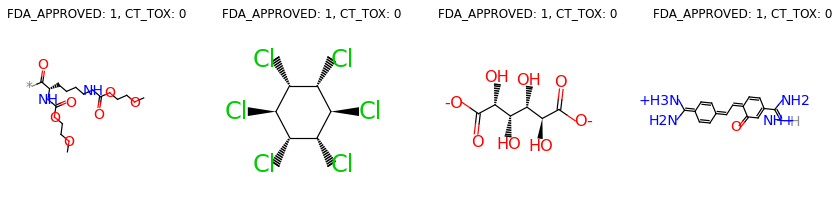

In [ ]:
%matplotlib inline
graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

# Define our Model

The model consists of two parts, a task-independent graph representation model and a task-specific module. We define a Graph Isomorphism Network (GIN) with 4 hidden layers as our representation model. The two prediction tasks will be jointly optimized through multi-task training by the task-specific module.


In [ ]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

# Train and Test
Now we can train our model. We setup an optimizer for our model, and put everything together into an Engine instance. It may take a few minutes to train our model.



In [ ]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1024)
solver.train(num_epoch=100)
solver.evaluate("valid")

04:22:33   Preprocess training set
04:22:46   {'batch_size': 1024,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'class': 'optim.Adam',
               'eps': 1e-08,
               'lr': 0.001,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'bce',
          'metric': ('auprc', 'auroc'),
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'edge_input_dim': None,
                    'eps': 0,
                    'hidden_dims': [256, 256, 256, 256],
                    'input_dim': 66,
                    'learn_eps': False,
                    'num_mlp_layer': 2,
                   

{'auprc [CT_TOX]': tensor(0.5049, device='cuda:0'),
 'auprc [FDA_APPROVED]': tensor(0.9796, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.8000, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.7891, device='cuda:0')}

To have some intuition of the model, we can investigate the predictions from our model. The following code selects one sample for each category, and plots the results.



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


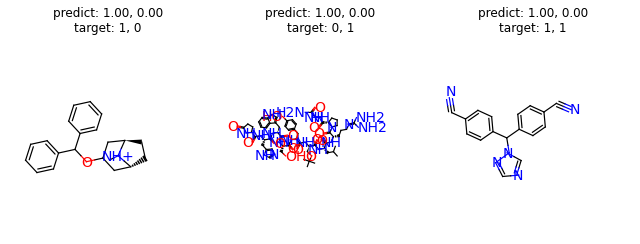

In [ ]:
from torch.nn import functional as F

samples = []
categories = set()
for sample in valid_set:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)
samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = F.sigmoid(task.predict(samples))
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred = ", ".join(["%.2f" % p for p in pred])
    target = ", ".join(["%d" % t for t in target])
    titles.append("predict: %s\ntarget: %s" % (pred, target))
graph = samples["graph"]
graph.visualize(titles, figure_size=(3, 3.5), num_row=1)